In [1]:
import numpy as np
import torch as ch
import matplotlib.pyplot as plt
from tqdm import tqdm
from aicsimageio import AICSImage
import ipywidgets as widgets

from confocalQuant.segmentation import (
    show_im,
    load_2D,
    threshold_im,
    update_image,
    load_3D,
    apply_thresh_all_Z,
    do_inference,
    get_anisotropy,
    sigmoid,
    toggle_segmentation,
    extract_channels,
    show_maxproj_with_outlines,
    hide_masks,
    run_med_filter,
    gamma_correct_image,
    int_to_float,
    float_to_int, 
    display_image, 
    on_filter_change, 
    toggle_filters,
    med_filter,
    gamma_correct_channel,
    bgrnd_subtract, 
    show_meanproj_with_outlines
    
)
from confocalQuant.quantification import get_all_expectations
from cellpose import models
from PIL import Image


/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


### Prep the image

In [4]:
# specify channels to load
channels = [0,2,1]# channel order Channels: Channels:  DAPI -> NeuN -> Tuj1 -> Cellrox

# specify path
path = './data/neuronbatch10132023_mitohealth/B06-1.czi'

# load image
img = AICSImage(path)
out = load_3D(img, channels)

# convert to float
out_float = int_to_float(out)

toggle, median, background_dict, gamma_dict, upper_dict, lower_dict = toggle_filters(out_float)
toggle

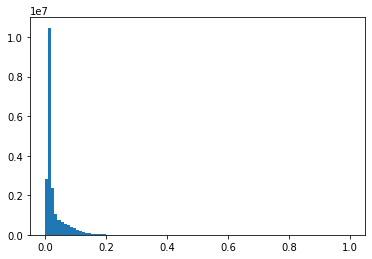

In [35]:
plt.hist(out_float[:,:,:,1].ravel(),100)
#plt.yscale('log')
None


In [84]:
# run med filter to remove noise
out_med = run_med_filter(out_float, kernel = 1)

# run background subtraction 
background_dict = {0: 0, 1: 95, 2: 0.0}

out_float_subtract = bgrnd_subtract(out_med, np.array(list(background_dict.values())))


100%|██████████| 20/20 [00:01<00:00, 10.77it/s]


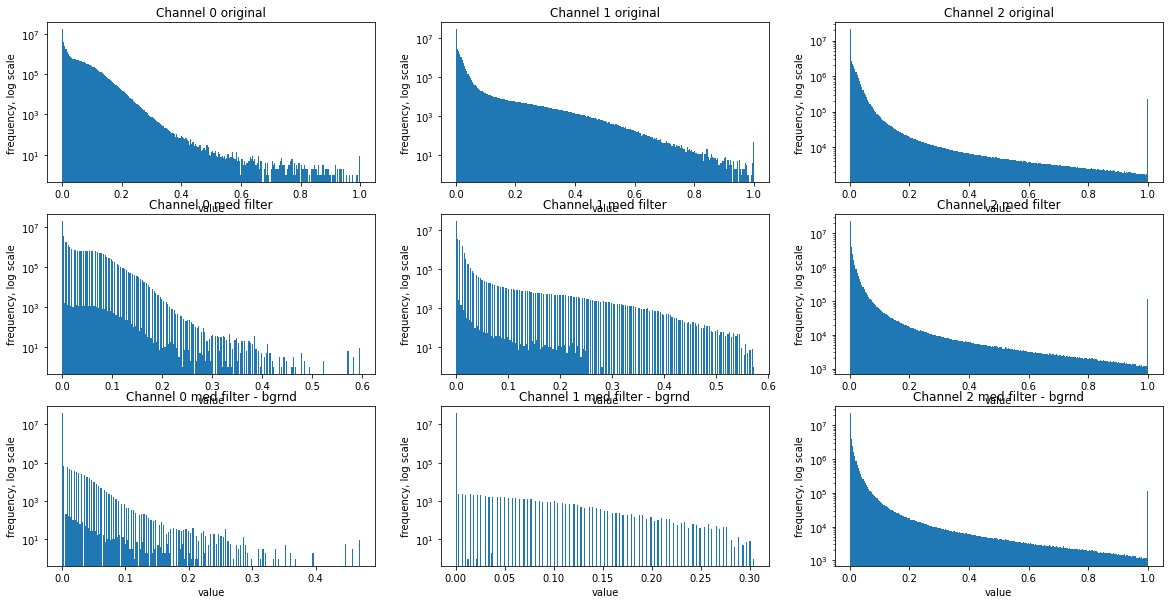

In [56]:
# # show plots
# fig, axs = plt.subplots(3, 3, figsize=(20, 10)) 

# for i in range(out_float.shape[-1]):
#     x = out_float[:,:,:,i].ravel()
#     axs[0,i].hist(x,256)
#     axs[0,i].set_yscale('log')
#     axs[0,i].set_title('Channel ' + str(i) + ' original')
#     axs[0,i].set_xlabel('value')
#     axs[0,i].set_ylabel('frequency, log scale')
#     #axs[0,i].set_ylim(0,0.1e6)
#     #axs[0,i].axvline(x=np.percentile(x, 99.9999), color='red')
#     None
    
# for i in range(out_med.shape[-1]):
#     x = out_med[:,:,:,i].ravel()
#     axs[1,i].hist(x,256)
#     axs[1,i].set_yscale('log')
#     axs[1,i].set_title('Channel ' + str(i) + ' med filter')
#     axs[1,i].set_xlabel('value')
#     axs[1,i].set_ylabel('frequency, log scale')
#     #axs[1,i].set_ylim(0,0.1e6)
#     #axs[1,i].axvline(x=np.percentile(x, 99.9999), color='red')
#     None

# for i in range(out_float_subtract.shape[-1]):
#     x = out_float_subtract[:,:,:,i].ravel()
#     axs[2,i].hist(x,256)
#     axs[2,i].set_yscale('log')
#     axs[2,i].set_title('Channel ' + str(i) + ' med filter - bgrnd')
#     axs[2,i].set_xlabel('value')
#     axs[2,i].set_ylabel('frequency, log scale')
#     #axs[2,i].set_ylim(0,0.1e6)
#     #axs[2,i].axvline(x=np.percentile(x, 99.9999), color='red')
#     None

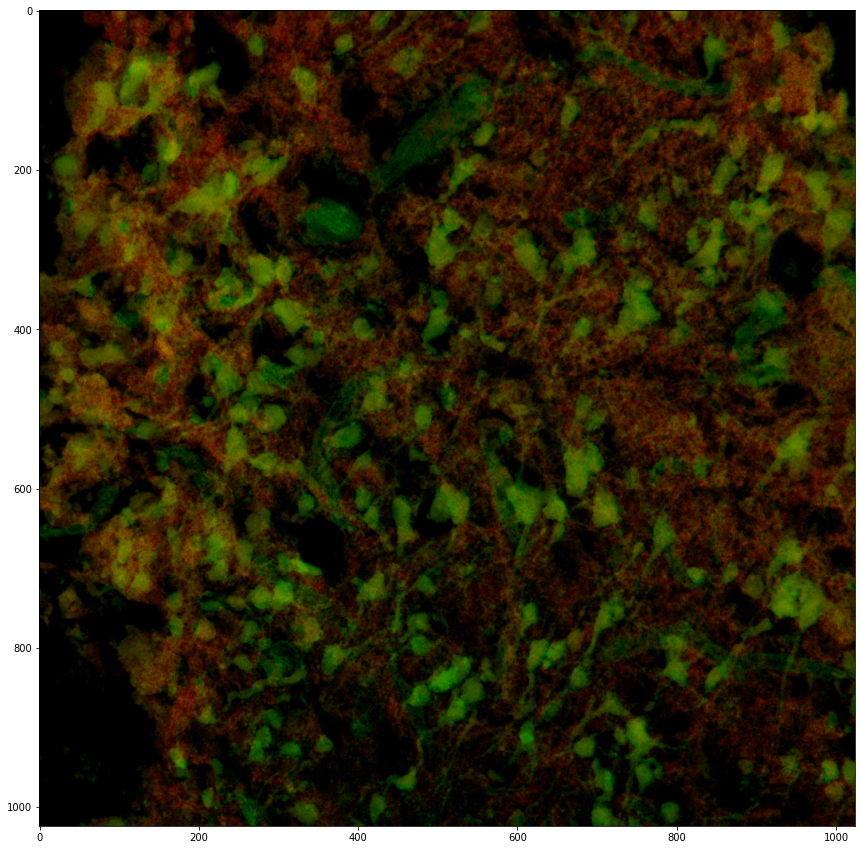

In [96]:
# g_correct = gamma_correct_image(out_float_subtract, {0: 1, 1: 0.7, 2: .4}, {0: 0, 1: 0, 2: 0}, {0: 90, 1: 90, 2: 100})

# # show projection
# out_med_gamma_sele = extract_channels([1,0], g_correct)
# out_med_gamma_mean_proj = (np.mean(out_med_gamma_sele, axis=(0)))
# plt.figure(figsize = (15,15))
# plt.imshow(out_med_gamma_mean_proj)

In [140]:
300*8

2400

In [85]:
g_correct = gamma_correct_image(out_float_subtract, {0: 1, 1: 1, 2: 1}, {0: 0, 1: 0, 2: 0}, {0: 100, 1: 99.5, 2: 100})
#g_correct = run_med_filter(g_correct, 3)


### Do inference

In [86]:
# get anisotropy
anisotropy = get_anisotropy(img)
print('Anisotropy: ' + str(anisotropy))

# load model
model = models.Cellpose(gpu = True, model_type='cyto2')

# run inference
masks, flows = do_inference(g_correct, do_3D=True, model=model, anisotropy=anisotropy, diameter=17, channels=[2,0], channel_axis=3, z_axis=0, min_size=500, normalize = False)

Anisotropy: 2.5163249334794178


    channels: list (optional, default None)
        list of channels, either of length 2 or of length number of images by 2.
        First element of list is the channel to segment (0=grayscale, 1=red, 2=green, 3=blue).
        Second element of list is the optional nuclear channel (0=none, 1=red, 2=green, 3=blue).
        For instance, to segment grayscale images, input [0,0]. To segment images with cells
        in green and nuclei in blue, input [2,3]. To segment one grayscale image and one
        image with cells in green and nuclei in blue, input [[0,0], [2,3]].

### Toggle through segmentation

In [87]:
# choose which channel(s) to show
out_float_subtract_g = gamma_correct_image(out_med, {0: 1, 1: 1, 2: 1}, {0: 0, 1: 0, 2: 0}, {0: 100, 1: 99.9, 2: 99.5})
out_med_gamma_sele = extract_channels([0,1], out_float_subtract_g)

# toggle through segmentation
toggle_segmentation(float_to_int(out_med_gamma_sele), masks)

In [88]:
# choose which channel(s) to show
out_float_subtract_g = gamma_correct_image(out_med, {0: 1, 1: 1, 2: 1}, {0: 0, 1: 0, 2: 0}, {0: 100, 1: 99.9, 2: 99.5})
out_med_gamma_sele = extract_channels([0,1], out_float_subtract_g)

# toggle through segmentation
toggle_segmentation(float_to_int(out_med_gamma_sele), masks_temp)

In [ ]:
toggle_segmentation(float_to_int(out_med_gamma_sele), masks)

In [70]:
import ast

from cellpose import models

def parse_dict(arg):
        # Safely evaluate the string as a Python literal expression
        return ast.literal_eval(arg)

In [77]:
parse_dict('{0: 0, 1: 0, 2: 0, 3:0}')

{0: 0, 1: 0, 2: 0, 3: 0}

100%|██████████| 20/20 [00:01<00:00, 19.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 20/20 [00:00<00:00, 20.12it/s]


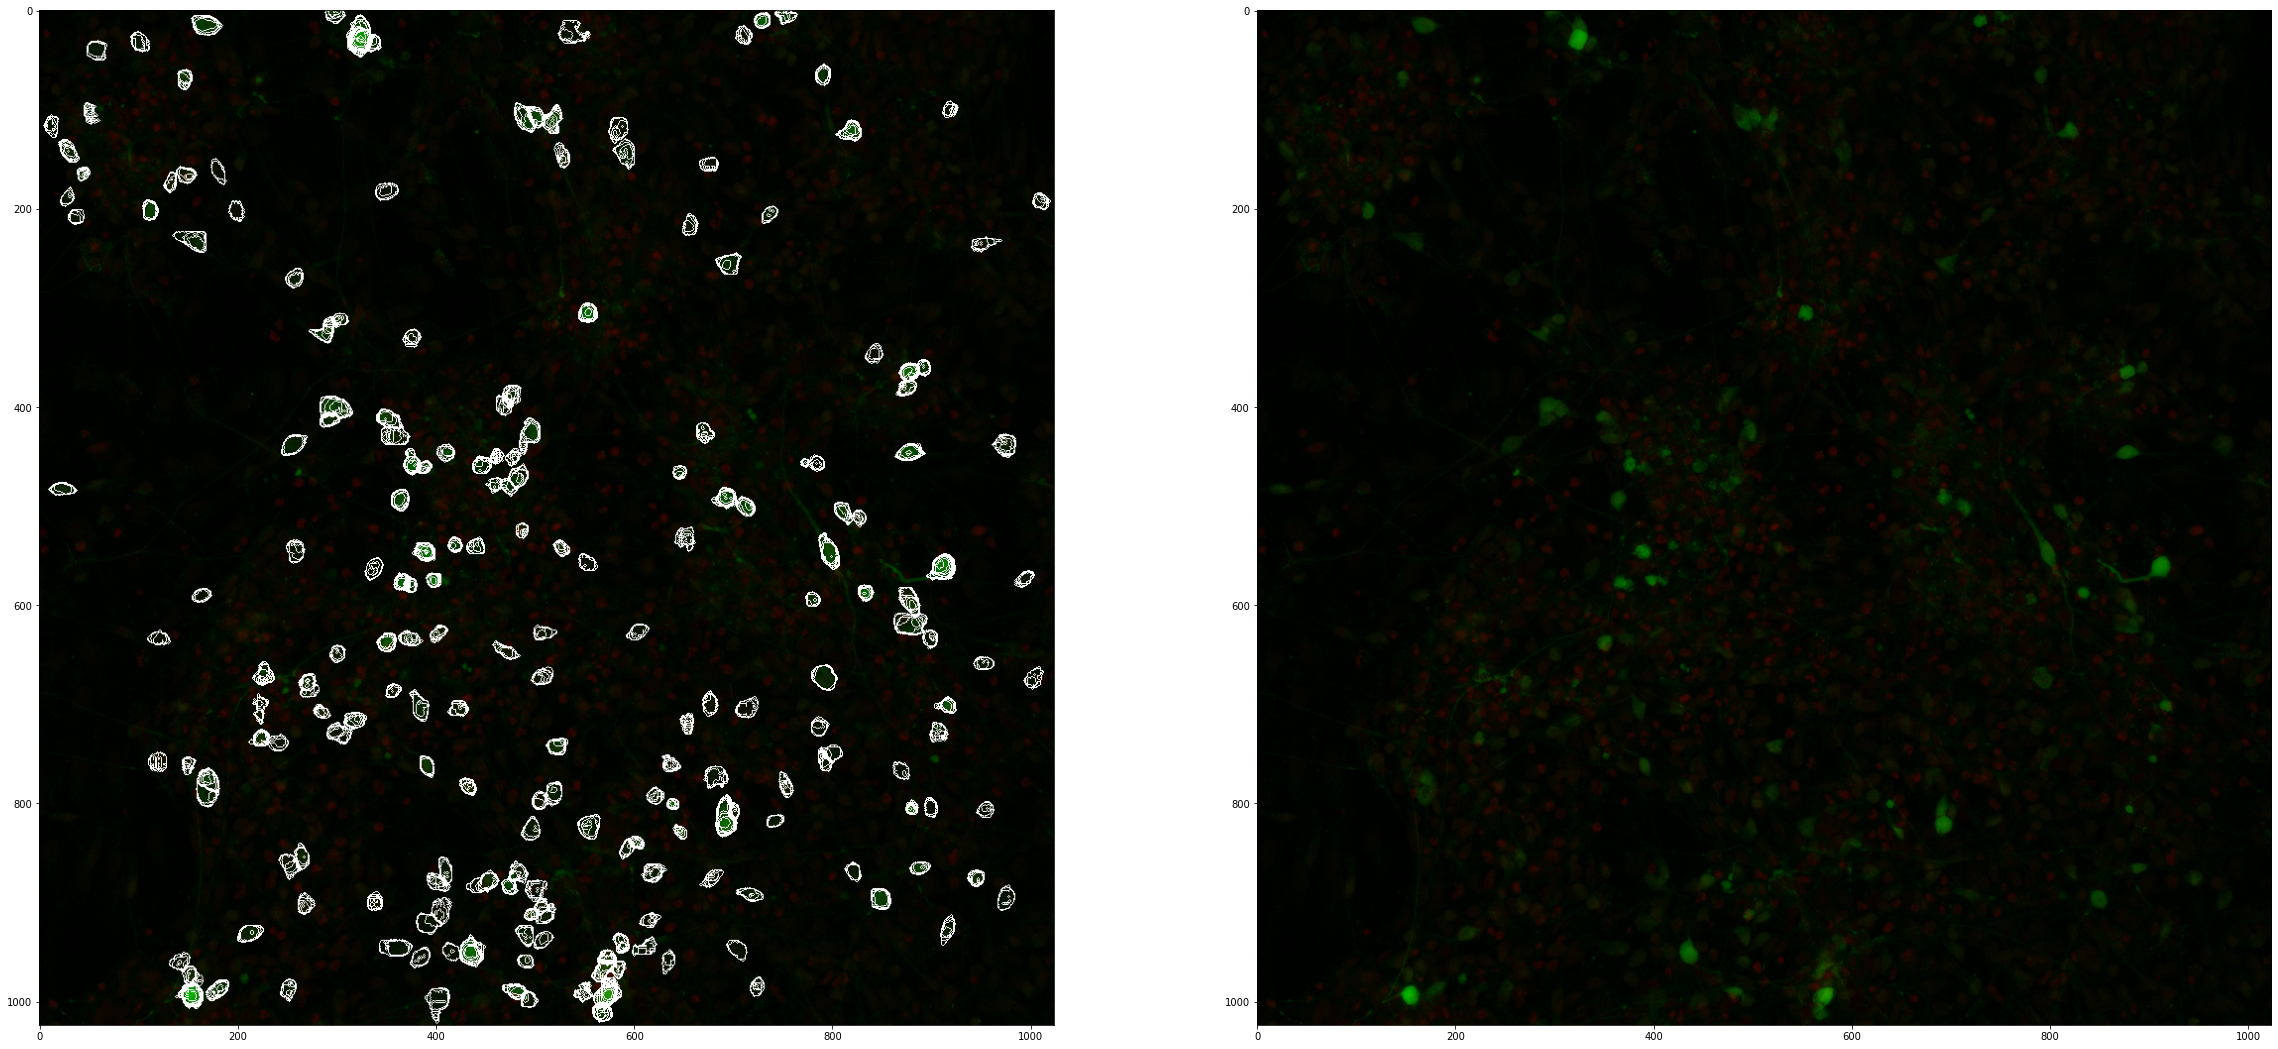

In [67]:
# plot mean intensity projections with and without segmentation
fig, axs = plt.subplots(1, 2, figsize=(40, 40)) 

# remove masks for the second plot
masks_temp = masks.copy()
masks_temp[masks_temp>0]=0

axs[0].imshow(show_maxproj_with_outlines(out_med_gamma_sele, masks)) # make this a mean projection
axs[1].imshow(show_maxproj_with_outlines(out_med_gamma_sele, masks_temp))

### Show 2D projections

100%|██████████| 20/20 [00:01<00:00, 12.18it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 20/20 [00:01<00:00, 12.12it/s]


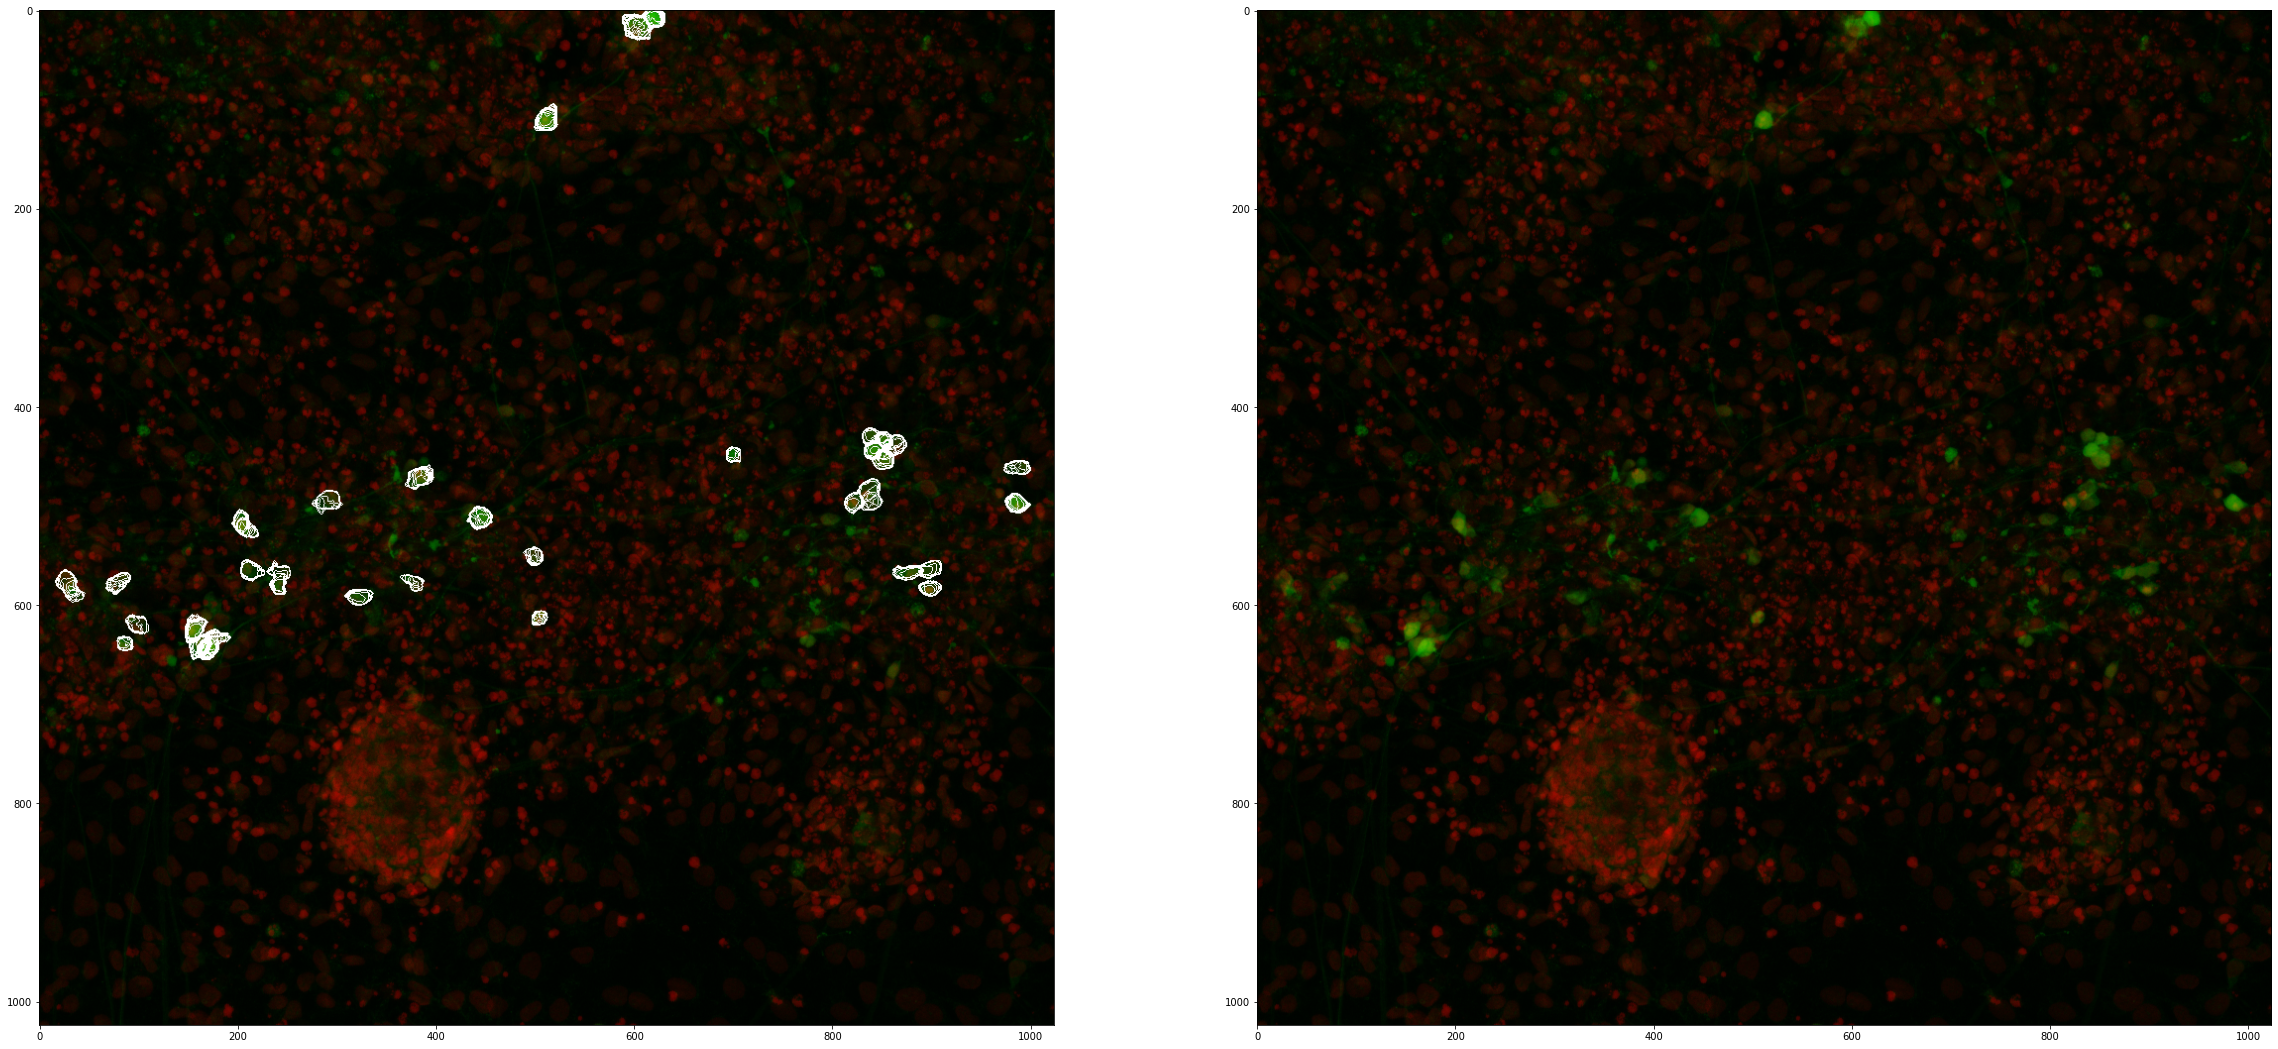

In [41]:
# plot mean intensity projections with and without segmentation
fig, axs = plt.subplots(1, 2, figsize=(40, 40)) 

# remove masks for the second plot
masks_temp = masks.copy()
masks_temp[masks_temp>0]=0

axs[0].imshow(show_meanproj_with_outlines(out_med_gamma_sele, masks)) # make this a mean projection
axs[1].imshow(show_meanproj_with_outlines(out_med_gamma_sele, masks_temp))

In [ ]:
# subtract background from green channel (x percent) before running model to remove the halucinations due to background
# Do that same subtraction for the channel of interest that we care about (ie. to remove background)
# Don't show max projection, but mean projection

### Get image stats

In [186]:
import numba as nb
def get_per_cell_expectation(matrix, probs, masks, maskID):
    index = masks==maskID
    return np.dot(matrix[index], probs[index])/np.sum(index)

def get_all_expectations(matrix, probs, masks):
    nchannels = matrix.shape[3]
    unique_masks = np.unique(masks)[1:]
    N = len(unique_masks)
    out = np.empty((N,nchannels))

    masks = masks.ravel()
    probs = probs.ravel()
    
    for j in range(nchannels):
        for i in tqdm(range(N)):
            out[i,j] = get_per_cell_expectation(matrix[:,:,:,j].ravel(), probs, masks, unique_masks[i])
    return out

In [188]:
# get expectations
Y = get_all_expectations(out_float_subtract, probs, masks)

100%|██████████| 233/233 [00:52<00:00,  4.46it/s]


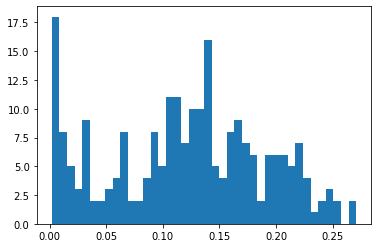

In [195]:
# show hist of NeuN per cell expectations
plt.hist(Y[:,1], 40)
None

In [228]:
# filter based on NeuN
dictionary = dict(zip(range(3), [0, 0.025,0]))

masks_copy = masks.copy()
hide_masks(Y, masks_copy, dictionary)

100%|██████████| 37/37 [00:02<00:00, 18.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 37/37 [00:02<00:00, 16.78it/s]


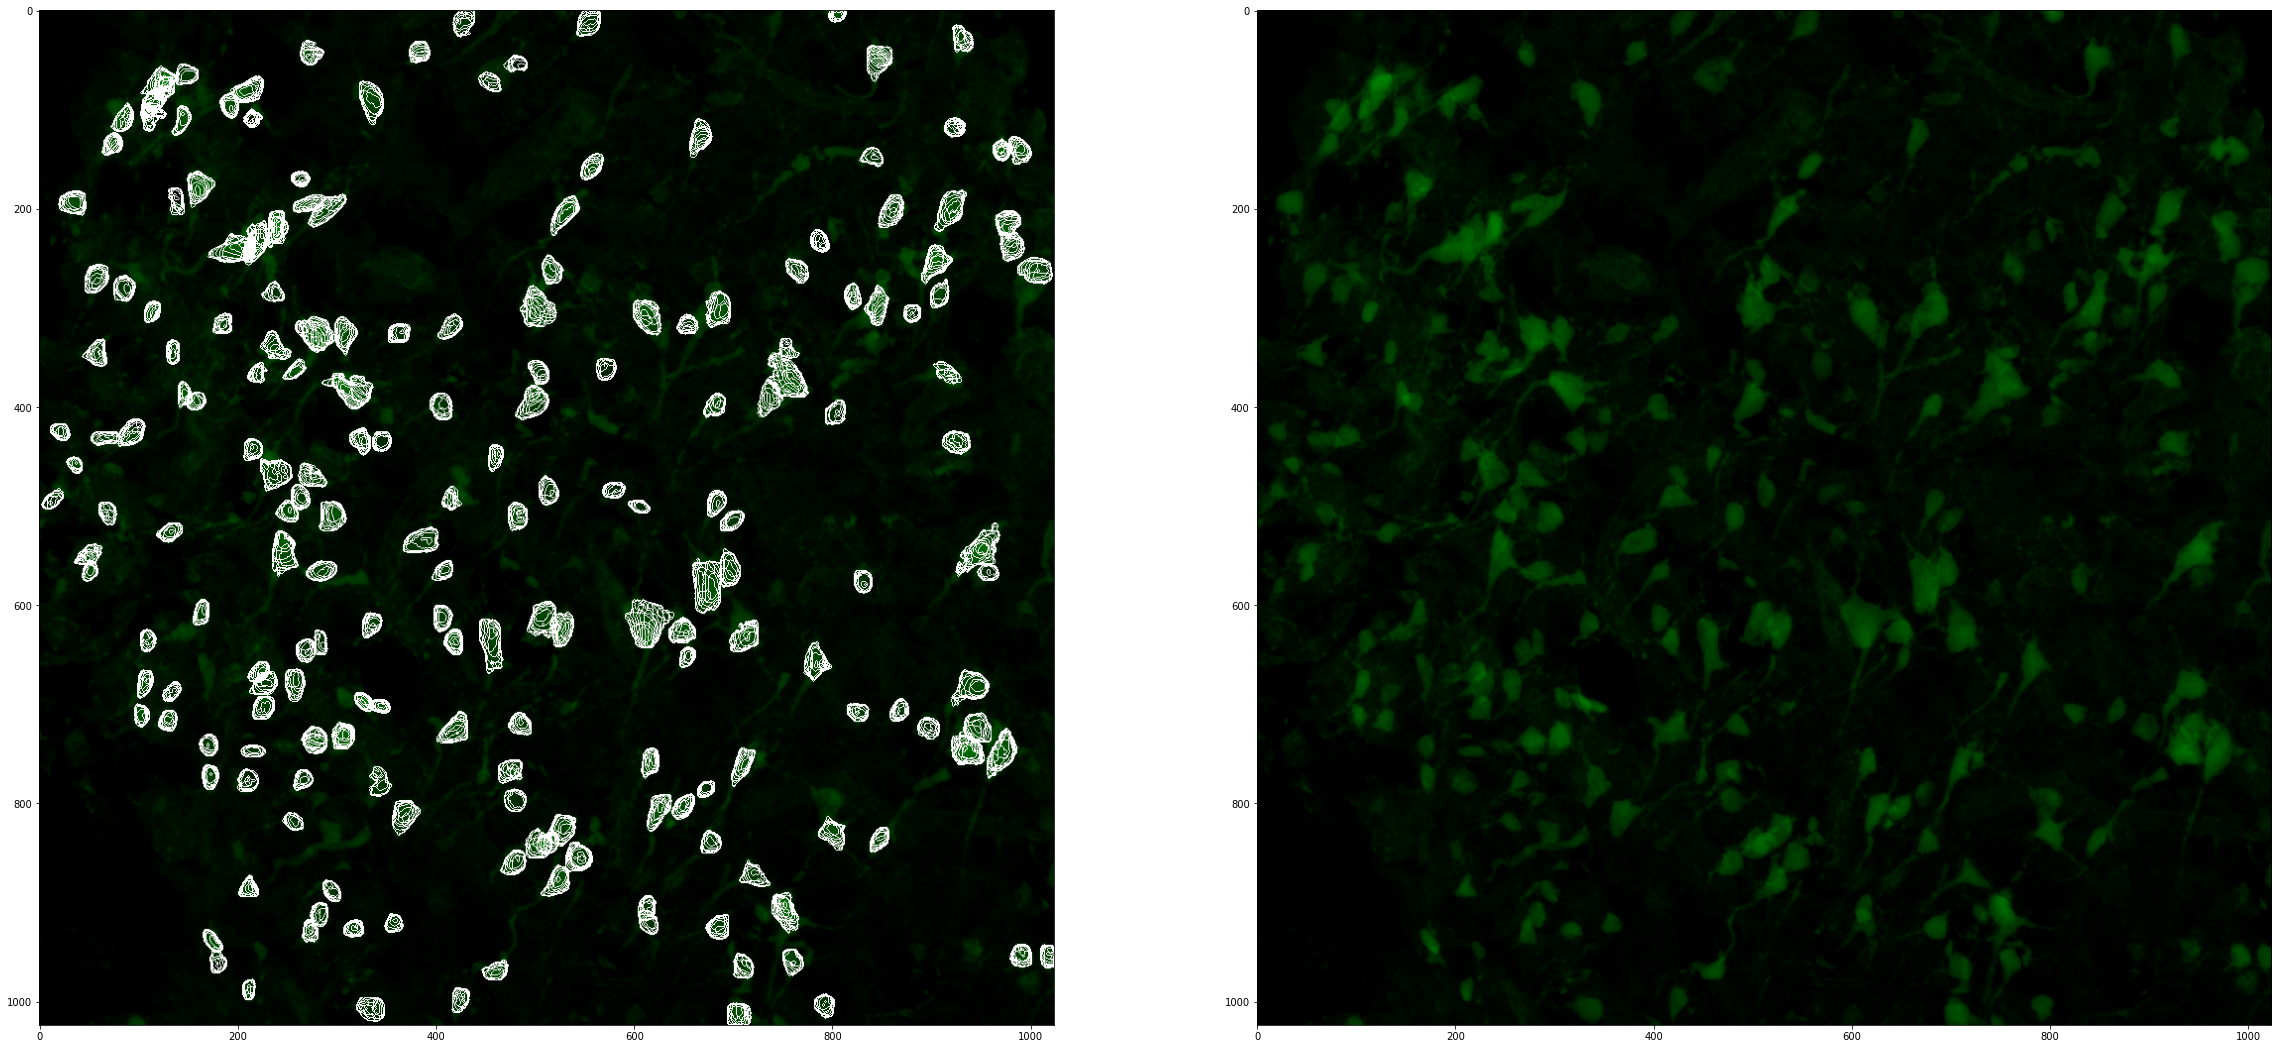

In [229]:
# plot mean intensity projections with and without segmentation
fig, axs = plt.subplots(1, 2, figsize=(40, 40)) 

# remove masks for the second plot
masks_temp = masks_copy.copy()
masks_temp[masks_temp>0]=0

out_float_subtract_g = gamma_correct_image(out_float_subtract, {0: 1, 1: 1, 2: .4}, {0: 0, 1: 0, 2: 0}, {0: 90, 1: 98.5, 2: 100})
out_med_gamma_sele = extract_channels([1], out_float_subtract_g)

axs[0].imshow(show_maxproj_with_outlines(out_med_gamma_sele, masks_copy)) # make this a mean projection


axs[1].imshow(show_maxproj_with_outlines(out_med_gamma_sele, masks_temp))

In [235]:
channel_zero_bgrnd_mean = np.mean(out_float_subtract[:,:,:,0][masks_copy==0])

In [232]:
Y_filtered = Y[Y[:,1]>0.025]

In [246]:
Y_filtered = np.concatenate((Y_filtered, (Y_filtered[:,0]-channel_zero_bgrnd_mean).reshape(-1,1)), axis=1)

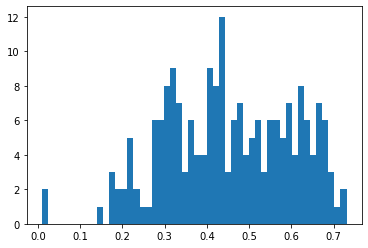

In [255]:
plt.hist(Y_filtered[:,2], 50)
None

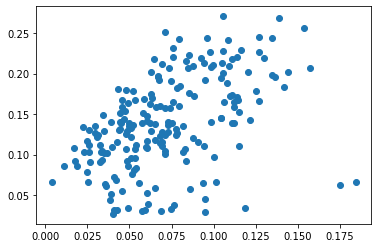

In [258]:
plt.scatter(Y_filtered[:,-1], Y_filtered[:,1])

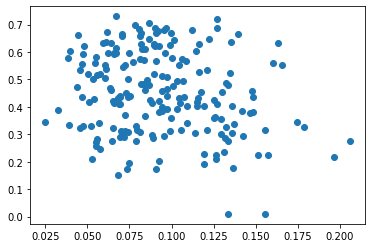

In [259]:
plt.scatter(Y_filtered[:,0], Y_filtered[:,2])

In [71]:
def get_czi_files(directory): # this function is chatGPT3
    files = [file for file in os.listdir(directory) if file.endswith(".czi")]
    return sorted(files)


In [89]:
import os
len(get_czi_files('./data/neuronbatch101823_cellrox///////'))

22

In [74]:
300*23

6900